In [73]:
import pandas as pd
from datetime import time
import datetime
import vectorbt as vbt
import os
import numpy as np
import requests
import json

pd.set_option('display.max_rows', 500)

In [22]:
def return_asset(name): 
    url_base = "https://delphi-assets.herokuapp.com/metaAssetForecasts_current/"+name+".json?_format=json&_size=max"
    loadHTML=requests.get(url_base)
    r=json.loads(loadHTML.text)
    cols = r['columns']
    df = pd.DataFrame(r['rows'])
    url_next = r['next_url']
    while url_next: 
        url_next = url_next
        loadHTML=requests.get(url_next)
        r=json.loads(loadHTML.text)
        df = df.append(pd.DataFrame(r['rows']))
        url_next = r['next_url']

    df.columns = cols
    df.drop('rowid', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['ts'] = pd.to_datetime(df['ts'])
    return df

In [23]:
df = return_asset('btc')

df = df.dropna()
df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'volume':'Volume', 'actual':'Close'}, inplace=True)
df = df.set_index('ts')

backtest_start = '2021-01-01'
df = df[df.index >= backtest_start]

In [42]:
df = df.astype(float)

In [43]:
df.dtypes

Close             float64
forecast          float64
forecast_lower    float64
forecast_upper    float64
Open              float64
                   ...   
ema-170           float64
ema-180           float64
ema-190           float64
ema-200           float64
atr               float64
Length: 67, dtype: object

In [106]:
df.columns

Index(['Close', 'forecast', 'forecast_lower', 'forecast_upper', 'Open', 'High',
       'Low', 'Volume', 'outflowmean', 'outflowmeanma7',
       'transactionscountinflow', 'addressescountoutflow',
       'estimatedleverageratio', 'mvrv', 'nvm', 'mca', 'mcda', 'range2y3y',
       'profitamountx', 'coinbasepremiumgap', 'velocitysupplytotal',
       'addressescountactive', 'hashratex', 'avtransactionvalue', 'tweets',
       'reserve', 'inflowmeanma7', 'lthsopr', 'range12m18m', 'profitpercentx',
       'takerbuyvolume', 'sendusd', 'mediantransactionvalue', 'googletrends',
       'rsi-05', 'rsi-10', 'rsi-15', 'rsi-20', 'rsi-25', 'rsi-30', 'bbup',
       'bbmid', 'bblow', 'macd', 'macdSignal', 'macdHist', 'ema-10', 'ema-20',
       'ema-30', 'ema-40', 'ema-50', 'ema-60', 'ema-70', 'ema-80', 'ema-90',
       'ema-100', 'ema-110', 'ema-120', 'ema-130', 'ema-140', 'ema-150',
       'ema-160', 'ema-170', 'ema-180', 'ema-190', 'ema-200', 'atr'],
      dtype='object')

In [44]:
df.head()

,Close,forecast,forecast_lower,forecast_upper,Open,High,Low,Volume,outflowmean,outflowmeanma7,...,ema-120,ema-130,ema-140,ema-150,ema-160,ema-170,ema-180,ema-190,ema-200,atr
ts,,,,,,,,,,,,,,,,,,,,,
2021-01-01,29359.9,30180.293514,28809.800323,31550.786705,28951.7,29627.1,28712.4,100902.0,9.619041,8.636457,...,17216.943454,16847.443842,16508.575762,16196.459078,15907.824441,15639.967249,15390.946085,15159.017013,14942.265437,914.7
2021-01-02,32193.3,32742.545441,31124.775330,34360.315551,29359.7,33233.5,29008.0,240865.0,15.668554,10.087099,...,17464.486537,17081.731722,16731.054120,16408.337765,16110.128485,15833.573480,15576.607454,15337.386469,15113.917522,4225.5
2021-01-03,32958.9,34175.490170,32614.576292,35736.404049,32192.9,34755.9,32029.6,155210.0,6.405402,9.923761,...,17720.592545,17324.131238,16961.236331,16627.550510,16319.429995,16033.869697,15768.676985,15521.904935,15291.479537,2726.3
2021-01-04,32022.6,33569.984290,32108.460967,35031.507612,33016.6,33587.5,28204.5,255269.0,8.561545,9.934542,...,17956.989362,17548.535341,17174.872695,16831.458451,16514.500429,16220.872390,15948.278345,15694.687082,15457.958348,5383.0
2021-01-05,33991.5,35076.876216,33623.038832,36530.713600,32015.4,34414.7,30010.5,202128.0,8.120025,9.771703,...,18222.022596,17799.572969,17413.406416,17058.743769,16731.606014,16428.715988,16147.650959,15886.276746,15642.371697,4404.2


In [45]:
df.vbt.ohlcv.plot()

FigureWidget({
    'data': [{'close': array([29359.9, 32193.3, 32958.9, ..., 50081. , 46703.6, 46745.5]),
    …

In [46]:
def dynamic_statement_build(dictionary, output_df, input_df='df'):
    index_key = 0
    for k2, v2 in dictionary.items(): 
        index_key += 1
        index_value = 1
        for v3 in v2: 
            if index_key == 1: 
                if index_value == 1: 
                    string = output_df + ' = (' + input_df + '[' + k2 + ']' + str(v3) 
                    index_value += 1
                else: 
                    if '[' in v3:
                        string = string + input_df + str(v3) + ')'
                    else:     
                        string = string + str(v3) + ')'
            else: 
                if index_value == 1: 
                    string = string + ' & (' + input_df + '[' + k2 + ']' + str(v3) 
                    index_value += 1
                else: 
                    if '[' in v3:
                        string = string + input_df + str(v3) + ')'
                    else:     
                        string = string + str(v3) +')'
    return string

In [97]:
exit_dict = {'strategy1':{"'Close'":[">=", "['forecast_upper']"]},
             'strategy2':{"'Close'":[">=", "['forecast_upper']"],"'rsi-05'":[">=", "70"]}, 
             'strategy3':{"'Close'":[">=", "['forecast_upper'] * .95"]}, 
             'strategy4':{"'Close'":[">=", "['forecast_upper']"], "'ema-10'":[".lt((", "['ema-10']", ".shift())"]},
             'strategy5':{"'Close'":[">=", "['forecast_upper']"], "'ema-10'":[".lt((", "['ema-10']", ".shift())"]},
             'strategy6':{"'Close'":[">=", "['forecast_upper']"]},
            #  'strategy6':{"'Close'":[">=", "['forecast_upper']"], "'ema-10'":[".lt((", "['ema-10']", ".shift())"]},
             'strategy7':{"'High'":[">=", "['forecast_upper']"], "'ema-10'":[".lt((", "['ema-10']", ".shift())"]},
}

entry_dict = {'strategy1':{"'Close'":["<=", "['forecast_lower']"]},
              'strategy2':{"'Close'":["<=", "['forecast_lower']"],"'rsi-05'":["<=", "30"]}, 
              'strategy3':{"'Close'":["<=", "['forecast_lower'] * 1.05"]}, 
              'strategy4':{"'Close'":["<=", "['forecast_lower']"], "'ema-10'":[".gt((", "['ema-10']", ".shift())"]}, 
              'strategy6':{"'Close'":["<=", "['forecast_lower']"], "'ema-10'":[".gt((", "['ema-10']", ".shift())"]},
              'strategy7':{"'Low'":["<=", "['forecast_lower']"], "'ema-10'":[".gt((", "['ema-10']", ".shift())"]}
}

In [ ]:
dictionary_example = { 'key': 'value'}
dictionary_multiple_values = {'key':['value1', 'value2']}
nested_dict = {'key':{"key_inner":"value_inner"}}

structure is KEY is column 
'close'
values are operator and column
">=" and "['forecast_upper']"
goal is to create ----> (df['Low']<=df['forecast_lower']) & (df['ema-10'].gt((df['ema-10']).shift()))

In [98]:
strategy_to_use = 'strategy6'

for k1, v1 in exit_dict.items(): 
    if k1 == strategy_to_use: 
        exit_statement = dynamic_statement_build(v1, 'exits', 'df')
for k1, v1 in entry_dict.items(): 
    if k1 == strategy_to_use: 
        entry_statement = dynamic_statement_build(v1, 'entries', 'df')

In [85]:
# (df['Low']<=df['forecast_lower']) & (df['ema-10'].gt((df['ema-10']).shift()))

In [86]:
entry_statement


"entries = (df['Close']<=df['forecast_lower']) & (df['ema-10'].gt((df['ema-10']).shift()))"

In [87]:
exec(exit_statement)
exec(entry_statement)

In [94]:
entries

ts
2021-01-01    False
2021-01-02    False
2021-01-03    False
2021-01-04     True
2021-01-05    False
2021-01-06     True
2021-01-07     True
2021-01-08    False
2021-01-09    False
2021-01-10    False
2021-01-11    False
2021-01-12    False
2021-01-13    False
2021-01-14    False
2021-01-15    False
2021-01-16    False
2021-01-17    False
2021-01-18     True
2021-01-19    False
2021-01-20    False
2021-01-21    False
2021-01-22    False
2021-01-23    False
2021-01-24    False
2021-01-25    False
2021-01-26    False
2021-01-27    False
2021-01-28    False
2021-01-29    False
2021-01-30    False
2021-01-31    False
2021-02-01    False
2021-02-02    False
2021-02-03    False
2021-02-04    False
2021-02-05    False
2021-02-06    False
2021-02-07    False
2021-02-08    False
2021-02-09    False
2021-02-10    False
2021-02-11    False
2021-02-12    False
2021-02-13    False
2021-02-14    False
2021-02-15    False
2021-02-16    False
2021-02-17    False
2021-02-18    False
2021-02-19    Fal

In [95]:
df[['Close', 'forecast_lower', 'forecast_upper','ema-10']].head()
# "entries = (df['Close']<=df['forecast_lower']) & (df['ema-10'].gt((df['ema-10']).shift()))"

,Close,forecast_lower,forecast_upper,ema-10
ts,,,,
2021-01-01,29359.9,28809.800323,31550.786705,26924.763256
2021-01-02,32193.3,31124.775330,34360.315551,27882.679027
2021-01-03,32958.9,32614.576292,35736.404049,28805.628295
2021-01-04,32022.6,32108.460967,35031.507612,29390.532241
2021-01-05,33991.5,33623.038832,36530.713600,30227.071834


In [91]:
df['Close'][0]

29359.9

In [93]:
df['Close'][1].shift()

AttributeError: 'numpy.float64' object has no attribute 'shift'

In [81]:
# exits

In [82]:
# entries[0]=True
# entries

In [99]:
fig = df['Close'].vbt.plot(trace_kwargs=dict(name='Price'))
fig = df['forecast_upper'].vbt.plot(trace_kwargs=dict(name='Upper Yhat'), fig=fig)
fig = df['forecast_lower'].vbt.plot(trace_kwargs=dict(name='Lower Yhat'), fig=fig)
fig = entries.vbt.signals.plot_as_entry_markers(df['Close'], fig=fig)
fig = exits.vbt.signals.plot_as_exit_markers(df['Close'], fig=fig)
fig.layout.update(title='Entry and Exit signals on predicted bounds',
                  autosize=False,
                  width=900,
                  height=500,)
fig.show()

In [100]:
# Signal stats
print(entries.vbt.signals.stats(settings=dict(other=exits)))

Start                              2021-01-01 00:00:00
End                                2021-12-14 00:00:00
Period                               348 days 00:00:00
Total                                               16
Rate [%]                                      4.597701
Total Overlapping                                    0
Overlapping Rate [%]                               0.0
First Index                        2021-01-04 00:00:00
Last Index                         2021-10-05 00:00:00
Norm Avg Index [-1, 1]                       -0.045389
Distance -> Other: Min                10 days 00:00:00
Distance -> Other: Max                78 days 00:00:00
Distance -> Other: Mean               37 days 01:30:00
Distance -> Other: Std      20 days 06:47:22.135991941
Total Partitions                                    10
Partition Rate [%]                                62.5
Partition Length: Min                  1 days 00:00:00
Partition Length: Max                  4 days 00:00:00
Partition 

In [101]:
df.dtypes

Close                      float64
forecast                   float64
forecast_lower             float64
forecast_upper             float64
Open                       float64
High                       float64
Low                        float64
Volume                     float64
outflowmean                float64
outflowmeanma7             float64
transactionscountinflow    float64
addressescountoutflow      float64
estimatedleverageratio     float64
mvrv                       float64
nvm                        float64
mca                        float64
mcda                       float64
range2y3y                  float64
profitamountx              float64
coinbasepremiumgap         float64
velocitysupplytotal        float64
addressescountactive       float64
hashratex                  float64
avtransactionvalue         float64
tweets                     float64
reserve                    float64
inflowmeanma7              float64
lthsopr                    float64
range12m18m         

In [102]:
dmac_pf = vbt.Portfolio.from_signals(df['Close'], entries, exits)
print(dmac_pf.stats())

Start                         2021-01-01 00:00:00
End                           2021-12-14 00:00:00
Period                          348 days 00:00:00
Start Value                                 100.0
End Value                              224.487791
Total Return [%]                       124.487791
Benchmark Return [%]                    59.215461
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        40.094239
Max Drawdown Duration           193 days 00:00:00
Total Trades                                    4
Total Closed Trades                             4
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 75.0
Best Trade [%]                          44.727786
Worst Trade [%]                        -13.590391
Avg Winning Trade [%]                   37.611406
Avg Losing Trade [%]                   -13.590391


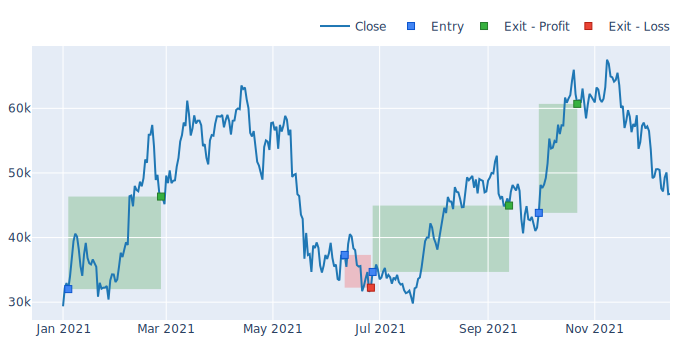

In [103]:
# print(dmac_pf.trades.records)
dmac_pf.trades.plot().show_svg()

In [104]:
# Now build portfolio for a "Hold" strategy
# Here we buy once at the beginning and sell at the end
hold_entries = pd.Series.vbt.signals.empty_like(entries)
hold_entries.iloc[0] = True
hold_exits = pd.Series.vbt.signals.empty_like(hold_entries)
hold_exits.iloc[-1] = True
hold_pf = vbt.Portfolio.from_signals(df['Close'], hold_entries, hold_exits)

In [105]:
# Equity
fig = dmac_pf.value().vbt.plot(trace_kwargs=dict(name='Value Delphi Model'))
hold_pf.value().vbt.plot(trace_kwargs=dict(name='Value (Hold)'), fig=fig)#.show_svg()

FigureWidget({
    'data': [{'name': 'Value Delphi Model',
              'showlegend': True,
              'ty…

In [ ]:
###################Scratch Below  =================== HERE BE DRAGONS

In [ ]:
stop here with an error

In [ ]:
np.arange(min_window, max_window+1, 10)

In [ ]:
import ipywidgets as widgets
fast_window = 30
slow_window = 80
min_window = 10
max_window = 200

# Pre-calculate running windows on data with time buffer
fast_ma, slow_ma = vbt.MA.run_combs(
    df['Open'], np.arange(min_window, max_window+1, 10),
    # df['Open'], np.arange(min_window, max_window+1), 
    r=2, short_names=['fast_ma', 'slow_ma'])

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)
print(fast_ma.ma.columns)
print(slow_ma.ma.columns)

In [ ]:
dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)

print(dmac_entries.columns) # the same for dmac_exits

In [ ]:
dmac_pf = vbt.Portfolio.from_signals(df['Close'], dmac_entries, dmac_exits)

In [ ]:
# Calculate performance of each window combination
metric = 'total_return'
dmac_perf = dmac_pf.deep_getattr(metric)

print(dmac_perf.shape)
print(dmac_perf.index)

In [ ]:
dmac_perf.idxmax() # your optimal window combination

In [ ]:
# Convert this array into a matrix of shape (99, 99): 99 fast windows x 99 slow windows
dmac_perf_matrix = dmac_perf.vbt.unstack_to_df(symmetric=True, 
    index_levels='fast_ma_window', column_levels='slow_ma_window')

print(dmac_perf_matrix.shape)

In [ ]:
dmac_perf_matrix.vbt.heatmap(
    xaxis_title='Slow window', 
    yaxis_title='Fast window')#.show_svg()

In [ ]:
fast_window = 30
slow_window = 40

# Pre-calculate running windows on data with time buffer
fast_ma = vbt.MA.run(df['Open'], fast_window)
slow_ma = vbt.MA.run(df['Open'], slow_window)

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

In [ ]:
dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)

In [ ]:
dmac_entries

In [ ]:
fig = df['Open'].vbt.plot(trace_kwargs=dict(name='Price'))
fig = fast_ma.ma.vbt.plot(trace_kwargs=dict(name='Fast MA'), fig=fig)
fig = slow_ma.ma.vbt.plot(trace_kwargs=dict(name='Slow MA'), fig=fig)
fig = dmac_entries.vbt.signals.plot_as_entry_markers(df['Open'], fig=fig)
fig = dmac_exits.vbt.signals.plot_as_exit_markers(df['Open'], fig=fig)

fig.show()#show_svg()

In [ ]:
dmac_pf = vbt.Portfolio.from_signals(df['Close'], dmac_entries, dmac_exits)

# Print stats
print(dmac_pf.stats())